# Facies classification using machine learning
#### Joshua Poirier, [NEOS](https://www.neosgeo.com/)
2016 SEG Machine Learning Competition  

## Introduction

This notebook demonstrates a novel way of training a machine learning algorithm to predict facies from well log data. The data set we use comes from a class exercise from The University of Kansas on Neural Networks and Fuzzy Systems. This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields.  

The data set we will use contains log data from nine wells that have been labeled with a facies type based on core examination. I use this log data to train support vector machine (SVM) classifiers to predict the facies type. SVM's are a type of supervised learning algorithm which can be trained on data to perform classification and regression. The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (in our case - facies). 

My approach is to build multiple models and allow them to **vote** - this process is called **blended modeling**. The novelty in my approach is that I build a model for each well in the training data and weight it based on its cross-correlation with the well of interest. This is intended to re-introduce some spatial geometry to the problem. Wells closer to the well of interest are more likely to exhibit a similar log character. Cross-correlation between close wells should show smaller lag and higher maximum correlation. Furthermore, the lag may be used to pre-process the **RELPOS** (relative position) channel - enhancing the predictive nature of that feature.  

To get started, let's load the libraries and supporting files!

In [42]:
# supporting visualization libraries
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

# libraries and supporting files
library(e1071)
#library(caret)

Warning message:
"package 'cowplot' was built under R version 3.2.5"
Attaching package: 'cowplot'

The following object is masked from 'package:ggplot2':

    ggsave



## Loading and splitting the data  

Blahblahblah

In [2]:
# function to load data
loadData <- function() {
    fname <- "../facies_vectors.csv"
    data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))
    
    data
}

In [3]:
# function to pre-process the data
preProcessData <- function(data) {
    # convert NM_M channel into a binary channel "isMarine"
    data$NM_M <- data$NM_M == "2"
    names(data)[10] <- "isMarine"

    # make the Facies channel more descriptive
    levels(data$Facies) <- c("SS", "CSiS", "FSiS", "SiSh", "MS", "WS", "D", "PS", "BS")
    
    data
}

In [4]:
# function to split the data
splitData <- function(data, testWell) {
    testIndex <- data$Well.Name == testWell
    
    train <- data[!testIndex,]
    test <- data[testIndex,]
    split <- list(train, test)
    
    split
}

In [5]:
# load and pre-process the data
data <- loadData()
data <- preProcessData(data)

# split the data
split <- splitData(data, "SHANKLE")
train <- split[[1]]
test <- split[[2]]
rm(data, split)

"Training Data"
head(train)

"Testing Data"
head(test)

[1] "Training Data"

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,FALSE,0.957
FSiS,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,FALSE,0.936
FSiS,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,FALSE,0.915
FSiS,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,FALSE,0.894


[1] "Testing Data"

,Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
938,CSiS,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,FALSE,1.000
939,CSiS,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,FALSE,0.984
940,CSiS,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,FALSE,0.968
941,CSiS,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,FALSE,0.952
942,CSiS,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,FALSE,0.935
943,CSiS,A1 SH,SHANKLE,2777.0,82.56,0.599,12.9,13.105,3.5,FALSE,0.919


## Exploratory data analysis  

Blahblahblah

In [6]:
# function to center/scale data
centerScaleData <- function(data) {
   
    # we only want to center/scale data which is numeric
    toScale <- sapply(data, class) == "numeric"
    
    # for each numeric feature in the data frame, center and scale
    for (i in 1:length(toScale)) {
        if (toScale[i]) {
            data[,i] <- scale(data[,i])
        }
    }
    
    data
}

In [7]:
# function to perform crosscorrelation between two vectors
crossCorrelate <- function(a, b) {

    # calculate cross-correlation between vectors a and b
    ccor <- ccf(a, b, lag.max=400, plot=F)

    # retrieve the maximum correlation and associated lag
    corr <- max(ccor[["acf"]][,,1])
    lag <- ccor[["lag"]][,,1][which.max(ccor[["acf"]][,,1])]
    
    if (is.na(corr)) {
        print(a)
        print(b)
    }
    # return maximum correlation and associated lag
    list(Correlation=corr, Lag=lag)
}

In [29]:
# apply a function "FUN" over columns named "features" to data frames "a" and "b"
loopFeatures <- function(a, b, FUN) {
    
    # preprocess
    a <- centerScaleData(a)
    b <- centerScaleData(b)
    
    # get list of columns for a and b dataframes
    features_a <- names(a)[names(a) != "Facies"]
    features_b <- names(b)[names(b) != "Facies"]
    
    # ensure a and b data frames have the same features
    try ((if (!all.equal(features_a, features_b)) stop("Error! Data frames do not have the same features.")))
    
    r <- data.frame(feature=factor(), correlation=numeric(), lag=numeric())
    features <- features_a[!features_a %in% c("Facies", "Formation", "Well.Name", "Depth", "RELPOS", "PE")]
    
    # loop through features
    for (feature in features) {
        av <- as.data.frame(a[,which(names(a) %in% feature)])
        bv <- as.data.frame(b[,which(names(b) %in% feature)])
        
        temp <- FUN(av, bv)
        
        r <- rbind(r, data.frame(feature=feature, correlation=temp[["Correlation"]], lag=temp[["Lag"]]))
    }
    
    r
}

In [9]:
trainBlendedModel <- function(data, cost, gamma) {

    # initialize model and params
    fits <- list()
    
    # retrieve list of wells in data set
    wells <- unique(data$Well.Name)
    
    # loop through wells
    for (well_i in wells) {
        # subset the data
        data_i <- data[data$Well.Name == well_i,]
        
        # build the model for this well
        fits[[well_i]] <- svm(Facies ~ ., data=data_i, kernel='radial', cost=cost, gamma=gamma)
    }
    
    fits
}

In [18]:
weightBlendedModel <- function(train, test) {
    
    # initialize weights list
    crossCorrs <- data.frame(trainWell=factor(), testWell=factor(), feature=factor(), correlation=numeric(), lag=numeric())
    
    # retrieve list of wells in training set
    trainWells <- unique(train$Well.Name)
    
    # loop through training wells
    for (well_i in trainWells) {
        # subset the data
        train_i <- train[train$Well.Name == well_i,]
        
        # calculate cross-correlation for each feature between current training well and testing well
        temp <- loopFeatures(train_i, test, crossCorrelate)
        temp$trainWell <- well_i
        temp$testWell <- test$Well.Name[1]
        
        # add current wells cross-correlation metrics to the data frame
        crossCorrs <- rbind(crossCorrs, temp)
    }
    
    crossCorrs
}

In [11]:
buildBlendedModel <- function(train, test, features, cost, gamma) {
    # initialize the blended model
    blendedModel <- list()
    
    # train and weight the models
    blendedModel[["fits"]] <- trainBlendedModel(train, cost, gamma)
    blendedModel[["weights"]] <- weightBlendedModel(train, test, features)
    
    # return the blended model
    blendedModel
}

In [12]:
tuneBlendedModel <- function(data, features) {
    
    # retrieve list of wells in data set
    wells <- unique(data$Well.Name)
    
    # loop through wells
    for (well_i in wells) {
        # split data into training and test (well_i is test)
        split <- splitData(data, well_i)
        
        # build blended model using training data
        buildBlendedModel(split[[1]], split[[2]], features, 10, 1)
    }
}

In [135]:
buildPlot <- function(data, well) {

    # build lag plot
    gl <- ggplot(data, aes(feature, trainWell, fill=lag)) + theme_economist_white(gray_bg=T) +
            geom_raster(alpha=.8) +
            labs(x="", y="Training Well", title=well) +
            scale_fill_distiller(palette="Spectral", name="", direction=-1) +
            theme(legend.position="right",
                  plot.title=element_text(size=8), 
                  axis.text=element_text(size=6),
                  axis.text.x=element_text(size=6, angle=90),
                  axis.title=element_text(size=8),
                  legend.text=element_text(size=8))
    

    # build correlation plot
    gc <- ggplot(data, aes(feature, trainWell, fill=correlation)) + theme_economist_white(gray_bg=T) +
            geom_raster(alpha=.8) +
            labs(x="", y="Training Well", title=well) +
            scale_fill_distiller(palette="Spectral", name="", direction=-1) +
            theme(legend.position="right",
                  plot.title=element_text(size=8), 
                  axis.text=element_text(size=6),
                  axis.text.x=element_text(size=6, angle=90),
                  axis.title=element_text(size=8),
                  legend.text=element_text(size=8))
    
    # return the plots
    list(lagPlot=gl, corrPlot=gc)
}

In [136]:
weights <- data.frame(trainWell=factor(), testWell=factor(), feature=factor(), correlation=numeric(), lag=numeric())
trainLoop <- train[train$Well.Name != "Recruit F9",]
wells <- unique(trainLoop$Well.Name)

for (well_i in wells) {
    split <- splitData(trainLoop, well_i)
    atrain <- split[[1]]
    atest <- split[[2]]
    
    weights <- rbind(weights, weightBlendedModel(atrain, atest))
}

lagPlots <- list()
corrPlots <- list()

wells <- unique(weights$testWell)
counter <- 1

for (well_i in wells) {
    subset <- weights[weights$testWell == well_i,]
    
    temp <- buildPlot(subset, well_i)
    lagPlots[[well_i]] <- temp$lagPlot
    corrPlots[[well_i]] <- temp$corrPlot
 
    counter <- counter + 1
}

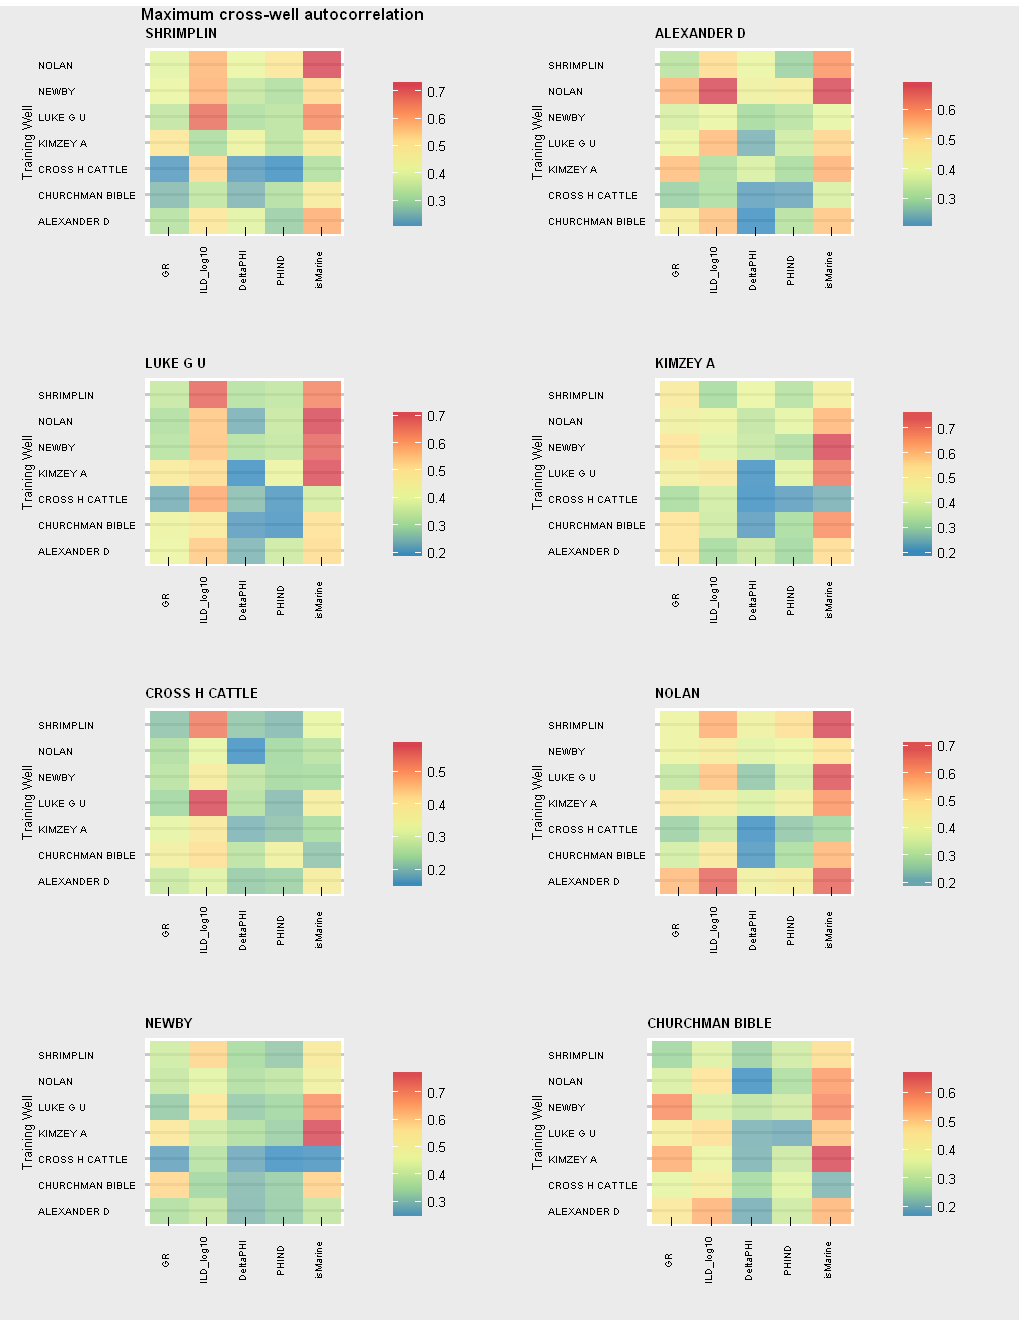

In [139]:
options(repr.plot.width=8.5, repr.plot.height=11)
g <- do.call(plot_grid, c(corrPlots, ncol=2))
ggdraw() + draw_plot(g, width=1, height=1, y=-.005) + draw_plot_label("Maximum cross-well autocorrelation", size=10)

feature,testWell,correlation
GR,ALEXANDER D,0.4195159
ILD_log10,ALEXANDER D,0.4695227
DeltaPHI,ALEXANDER D,0.3100069
PHIND,ALEXANDER D,0.3260050
isMarine,ALEXANDER D,0.5201572
GR,CHURCHMAN BIBLE,0.4217313


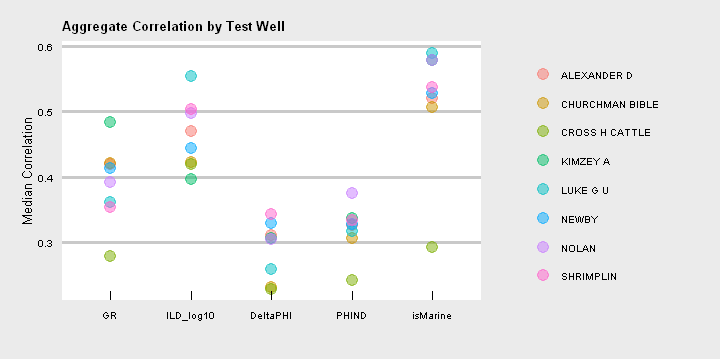

In [179]:
options(repr.plot.width=6, repr.plot.height=3)

agg <- aggregate(correlation ~ feature + testWell, data=weights, FUN=mean)
head(agg)
ggplot(agg, aes(x=feature, y=correlation, group=testWell, color=testWell)) + 
    theme_economist_white(gray_bg=T) +
    geom_point(size=3, alpha=.5) +
    scale_color_discrete() +
    labs(x="", y="Median Correlation", title="Aggregate Correlation by Test Well") +
    theme(legend.position="right", legend.text=element_text(size=6), legend.title=element_blank()) +
    theme(axis.text=element_text(size=6), axis.title=element_text(size=8)) +
    theme(plot.title=element_text(size=8))

## Model tuning  

Blahblahblah

In [4]:
# function to tune model

In [5]:
# execute model tuning, print the model tuning parameters

## Training  

Blahblahblah

In [6]:
# function to train model

In [7]:
# execute model training

## Testing  

Blahblahblah

In [8]:
# function to test model (on SHANKLE well)

In [9]:
# execute model testing

## Conclusions  

Blahblahblah